# Run a CNN with the labels dataset

In [1]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras

from PIL import Image


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [2]:

train_dir = r"C:\Users\Andrea\Desktop\Nuevo Train 20241021"
filenames = os.listdir(train_dir)
labels = [x.split("class")[1] for x in filenames]
labels2 = [int(l.split(".")[0]) for l in labels]
train_data = pd.DataFrame({"filename": filenames, "label": labels2})

test_dir = r"C:\Users\Andrea\Desktop\Nuevo Validation 20141021"
filenames = os.listdir(test_dir)
labels = [x.split("class")[1] for x in filenames]
labels2 = [int(l.split(".")[0]) for l in labels]
test_data = pd.DataFrame({"filename": filenames, "label": labels2})
number_classes=len(np.unique(train_data['label']))

In [3]:
for key in train_data.groupby('label').groups.keys():
    if len(train_data.groupby('label').groups[key])<100:
        train_data.drop(train_data.index[train_data['label'] == key], inplace=True)
        test_data.drop(test_data.index[test_data['label'] == key], inplace=True)

In [14]:
le = LabelEncoder()
new_labels=le.fit_transform(train_data['label'])
train_data['label']=new_labels
new_val_labels=le.transform(test_data['label'])
test_data['label']=new_val_labels


In [15]:
# Split into validation and test
labels = test_data['label']

X_train, X_temp = train_test_split(test_data, test_size=0.5, stratify=labels, random_state = 42)


print('The shape of Validation data',X_train.shape)
print('The shape of Test data',X_temp.shape)
print('The shape of Train data',train_data.shape)

The shape of Validation data (1032, 2)
The shape of Test data (1033, 2)
The shape of Train data (4248, 2)


In [11]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=12, dim=(340,340), n_channels=3,
                 n_classes=12, shuffle=True, data_type='Train'):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.data_type = data_type 
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Find list of IDs
      list_IDs_temp = [self.list_IDs.iloc[k] for k in indexes]

      # Generate data
      X, y = self.__data_generation(list_IDs_temp)

      return X, y

    def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.list_IDs))
      if self.shuffle == True:
          np.random.shuffle(self.indexes)


    def __data_generation(self, list_IDs_temp):
      'Generates data containing batch_size samples'
      if self.data_type == 'Train':
        data_loc = r"C:\Users\Andrea\Desktop\Nuevo Train 20241021" #Add your path for Train images
      if self.data_type == 'Val':
        data_loc = r"C:\Users\Andrea\Desktop\Nuevo Validation 20141021" #Add your path for Test images
      # Generate data
      X = np.empty((self.batch_size, *self.dim, self.n_channels))
      y = np.empty(self.batch_size,dtype='float32')
      # Generate data
      for i, ID in enumerate(list_IDs_temp):
          # Store sample
          x_file_path = os.path.join(data_loc, ID['filename'])
          img=np.array(Image.open(x_file_path)) 
          T_image=tf.image.resize(img, self.dim, method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=True)
          X[i,] = tf.cast(T_image,'int64')
          y[i] = ID['label']
      return X, y

In [16]:
# Parameters
image_size = 340
image_channel = 3
bat_size = 24

T_params = {'dim': (340,340),
          'batch_size': 24,
          'n_classes': number_classes,
          'n_channels': image_channel,
          'shuffle': True,
          'data_type':'Train'}

V_params = {'dim': (340,340),
          'batch_size': 24,
          'n_classes': number_classes,
          'n_channels': image_channel,
          'shuffle': True,
          'data_type':'Val'}

Test_params = {'dim': (340,340),
          'batch_size': len(X_train),
          'n_classes': number_classes,
          'n_channels': image_channel,
          'shuffle': False,
          'data_type':'Val'}

training_generator = DataGenerator(train_data,**T_params)
validation_generator = DataGenerator(X_temp,**V_params)
test_generator = DataGenerator(X_train,**Test_params)

In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [8]:

model = Sequential()

model.add(layers.RandomFlip("horizontal_and_vertical", input_shape=(image_size,image_size,image_channel)))
model.add(layers.Rescaling(1./255))

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Bloack 1 
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Fully Connected layers 
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
# Output layer
model.add(Dense((number_classes),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 340, 340, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 340, 340, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 338, 338, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 338, 338, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 169, 169, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 169, 169, 32)      0

In [9]:
model.compile(optimizer='adam',loss= tf.keras.losses.SparseCategoricalCrossentropy(),metrics=["sparse_categorical_accuracy"])

In [17]:
CNN_model = model.fit(training_generator,
                    validation_data = validation_generator, 
                    #callbacks=[early_stoping,learning_rate_reduction],
                    epochs = 50)

Epoch 1/50
126/177 [====================>.........] - ETA: 1:28 - loss: 1.8359 - sparse_categorical_accuracy: 0.5291

c:\Users\Andrea\anaconda3\envs\myenv\lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (133749225 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


143/177 [=======================>......] - ETA: 59s - loss: 1.8162 - sparse_categorical_accuracy: 0.5288 

c:\Users\Andrea\anaconda3\envs\myenv\lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (162333081 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


168/177 [===========================>..] - ETA: 15s - loss: 1.7755 - sparse_categorical_accuracy: 0.5322

c:\Users\Andrea\anaconda3\envs\myenv\lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (120428676 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


177/177 [==============================] - 333s 2s/step - loss: 1.7525 - sparse_categorical_accuracy: 0.5355 - val_loss: 24.1812 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/50
177/177 [==============================] - 399s 2s/step - loss: 1.2273 - sparse_categorical_accuracy: 0.6033 - val_loss: 2.5507 - val_sparse_categorical_accuracy: 0.3198
Epoch 3/50
177/177 [==============================] - 326s 2s/step - loss: 1.1060 - sparse_categorical_accuracy: 0.6365 - val_loss: 3.2311 - val_sparse_categorical_accuracy: 0.3479
Epoch 4/50
177/177 [==============================] - 327s 2s/step - loss: 1.0058 - sparse_categorical_accuracy: 0.6601 - val_loss: 2.0819 - val_sparse_categorical_accuracy: 0.4554
Epoch 5/50
177/177 [==============================] - 326s 2s/step - loss: 0.9406 - sparse_categorical_accuracy: 0.6723 - val_loss: 3.5518 - val_sparse_categorical_accuracy: 0.3983
Epoch 6/50
177/177 [==============================] - 313s 2s/step - loss: 0.8831 - sparse_categorica

In [18]:
# Evaluate for train generator
loss,acc = model.evaluate(training_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for training data is: {0}%'.format(round(acc*100,2)))
print('The Loss of the model for training data is:',loss)

# Evaluate for validation generator
loss,acc = model.evaluate(validation_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for validation data is: {0}%'.format(round(acc*100,2)))
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for training data is: 97.5%
The Loss of the model for training data is: 0.07009538263082504
The accuracy of the model for validation data is: 66.86%
The Loss of the model for validation data is: 1.7333256006240845


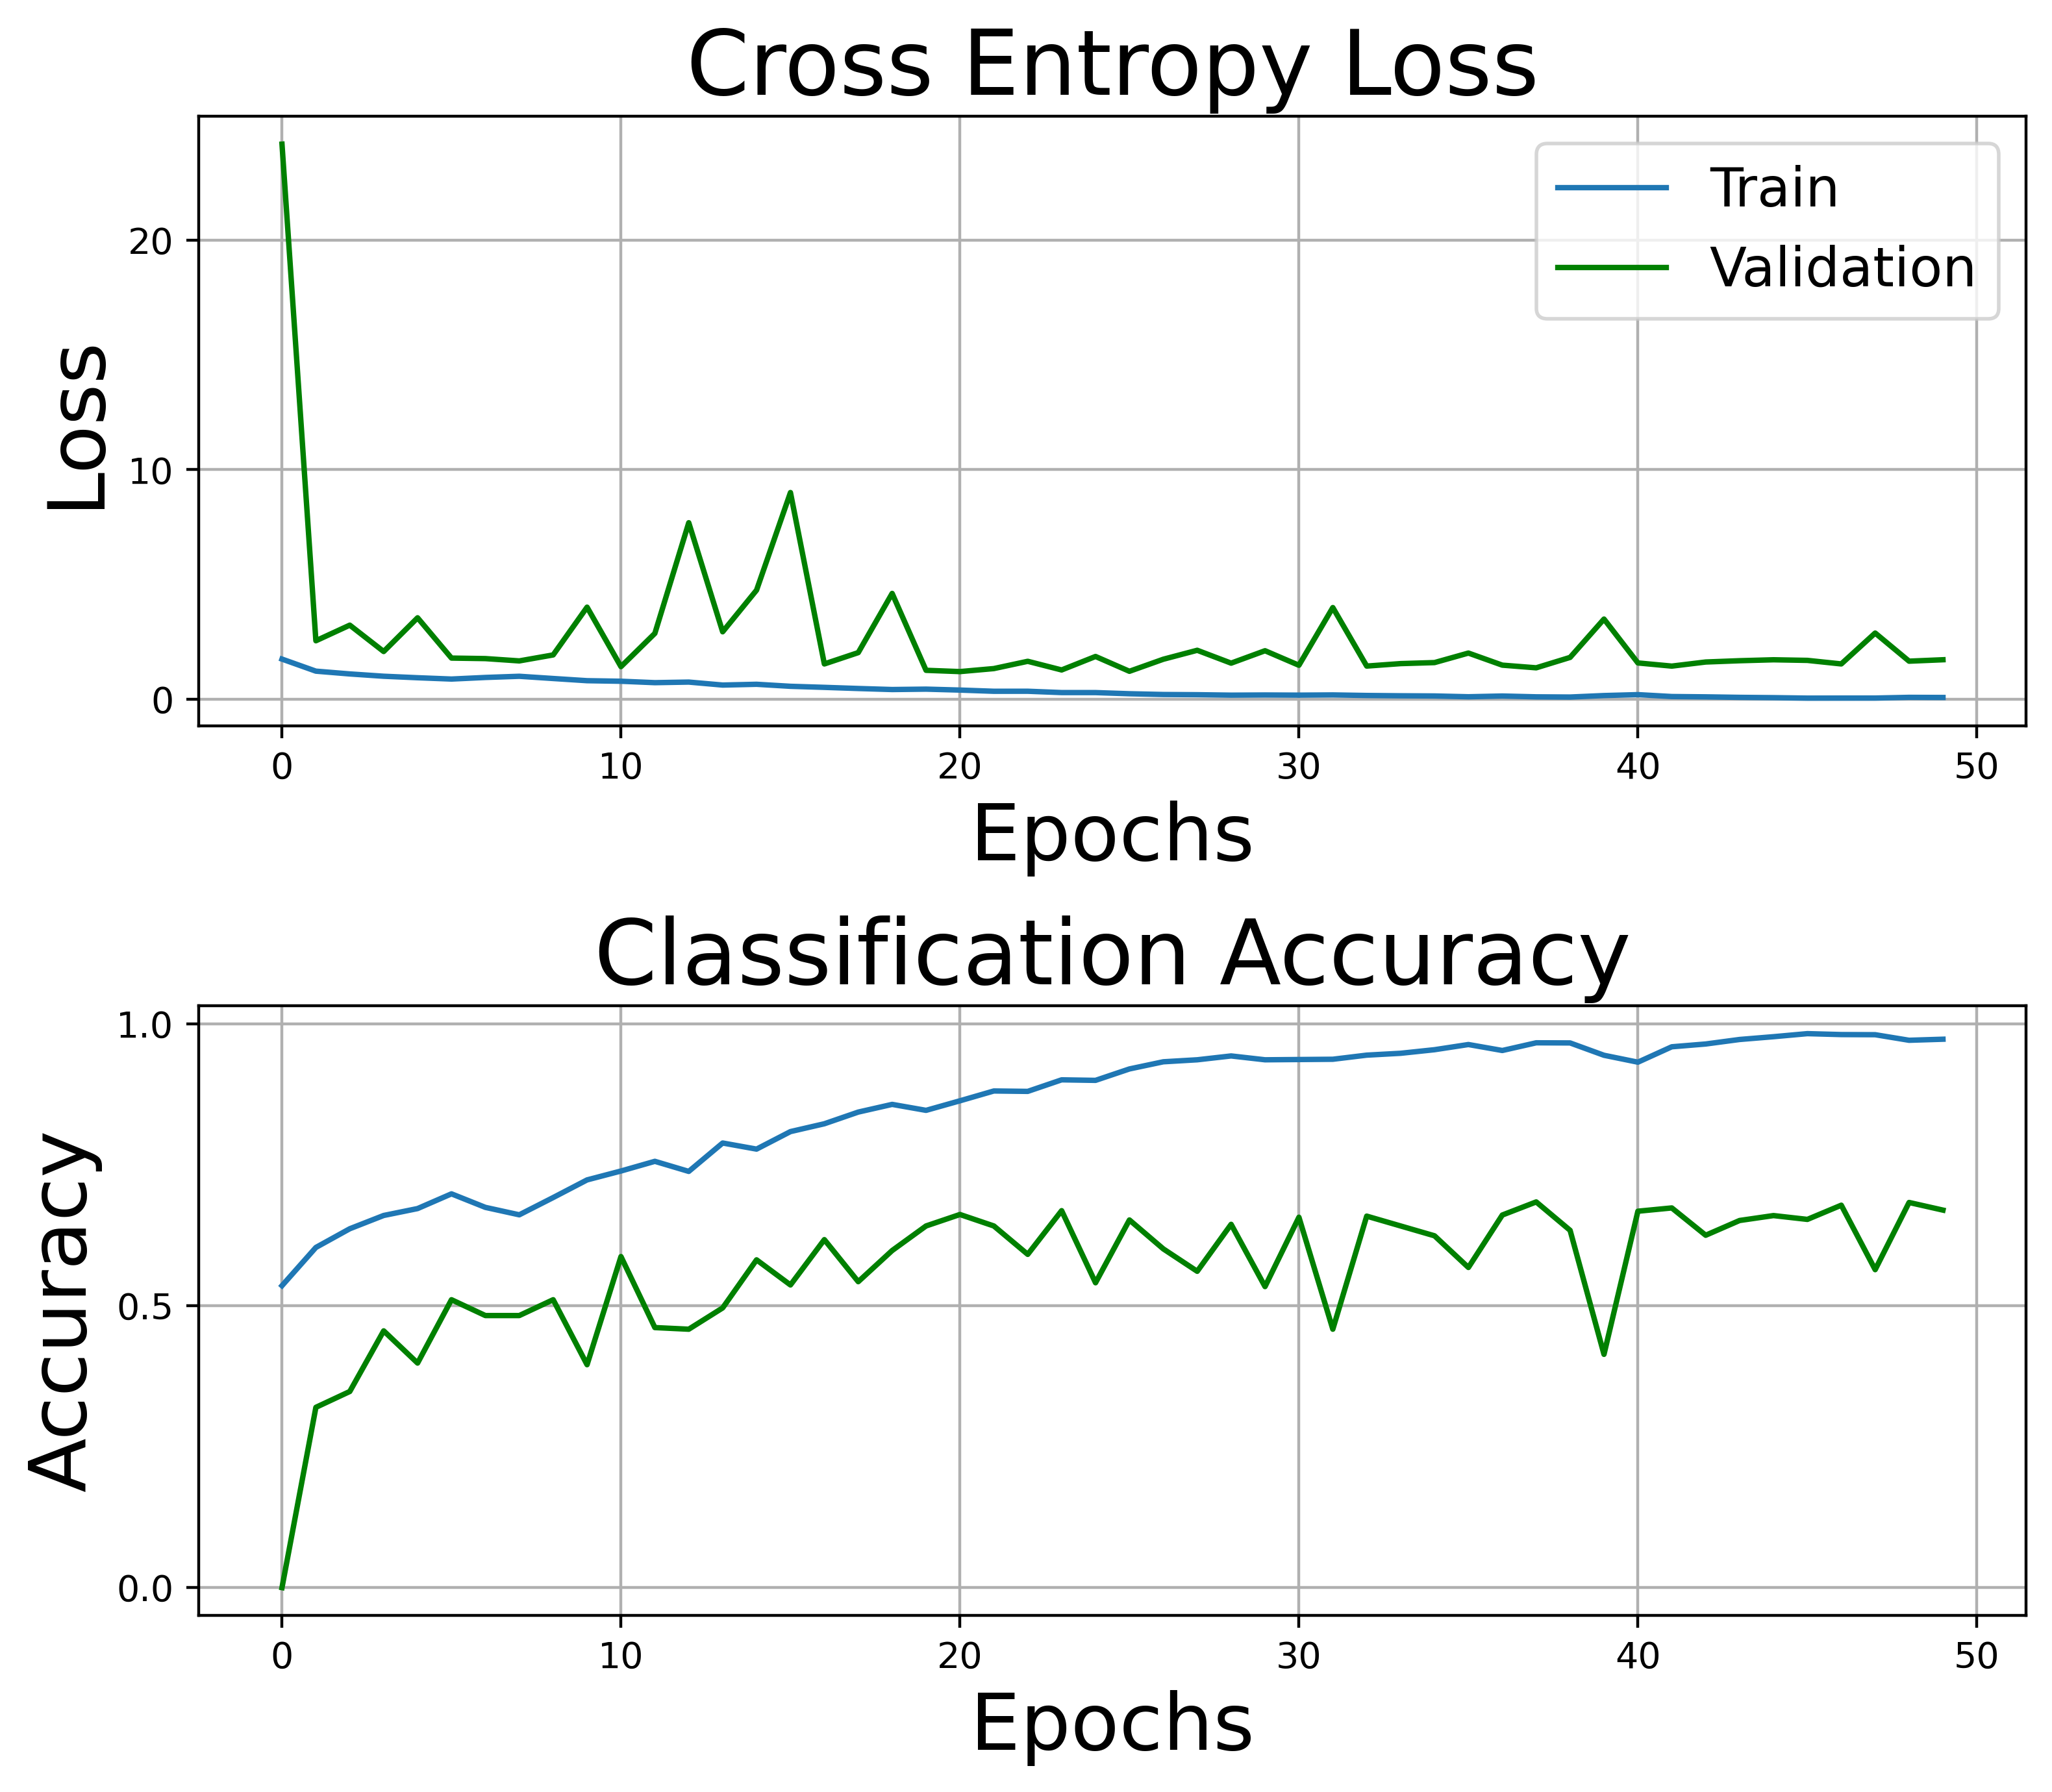

In [19]:
error = pd.DataFrame(CNN_model.history)

fig=plt.figure(figsize=(8,7),dpi=400)

plt.subplot(211)
plt.title('Cross Entropy Loss',fontsize=25)
plt.xlabel('Epochs',fontsize=22)
plt.ylabel('Loss',fontsize=22)

plt.plot(error['loss'], label='Train')
plt.plot(error['val_loss'], label='Validation',color='g')
plt.legend(loc="upper right", fontsize=15)
plt.grid()

plt.subplot(212)
plt.title('Classification Accuracy',fontsize=25)
plt.xlabel('Epochs',fontsize=22)
plt.ylabel('Accuracy',fontsize=22)
plt.plot(error["sparse_categorical_accuracy"], label='Train')
plt.plot(error['val_sparse_categorical_accuracy'], label='Validation', color='g')

plt.grid()
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
fig.tight_layout()
plt.show()